In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import numpy as np
import matplotlib.pyplot as plt
fig_width = 12
%matplotlib inline


TODO: issues at github

TODO: mark all pauses 

TODO: copy working notebooks inot functions in the script + main folder


# the switching binomial generative model
## the data to model

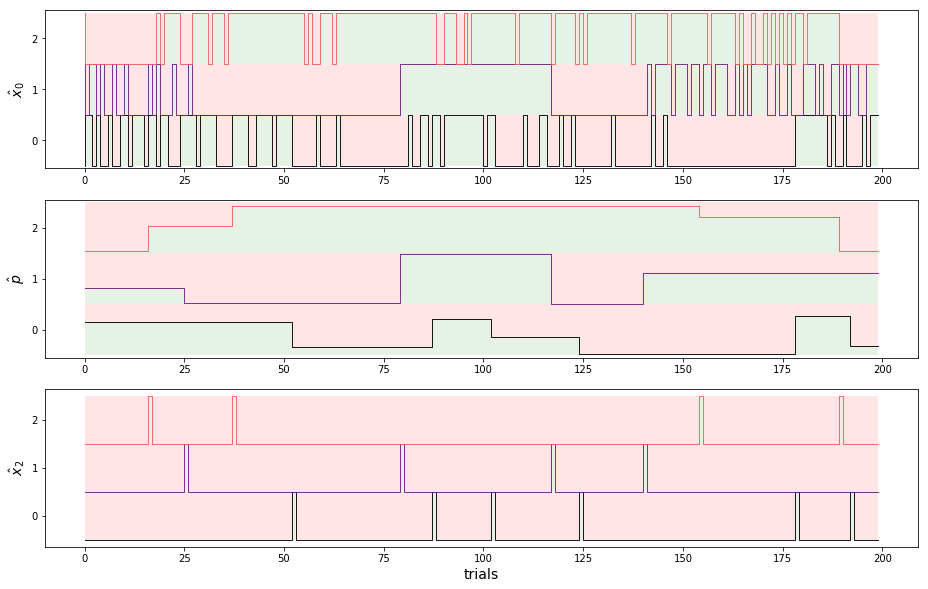

In [2]:
import sys
sys.path.append('..')

from aSPEM import binomial_motion, aSPEM

import time
a = aSPEM(mode='pari', timeStr = time.strftime("%Y-%m-%d_%H%M%S", time.localtime()))
fig, axs, p = a.plot()

In [3]:
p.shape

(200, 3, 3)

In [6]:
i_block = 0
print('occurrences=', p[:, i_block, 0])
print('p=', p[:, i_block, 1])
print('switches=', p[:, i_block, -1])

occurrences= [ 0.  1.  1.  0.  1.  0.  0.  1.  0.  0.  1.  1.  0.  1.  1.  1.  0.  1.
  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  0.
  0.  0.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.
  1.  1.]
p= [ 0.64752352  0.64752352  0.64752352  0.64752352  0.64752352  0.64752352
  0.64752352  0.64752352  0.64752352  0.64752352  0.64752352  0.64752352
  0.64752352  0.64752352 

In [8]:
a.exp['N_trials']



200

In [ ]:
# -*- coding: utf8 -*-
"""
 An implementation of:
 @TECHREPORT{ adams-mackay-2007,
    AUTHOR = {Ryan Prescott Adams and David J.C. MacKay},
    TITLE  = "{B}ayesian Online Changepoint Detection",
    INSTITUTION = "University of Cambridge",
    ADDRESS = "Cambridge, UK",
    YEAR = "2007",
    NOTE = "arXiv:0710.3742v1 [stat.ML]"
 }
 
 adapted from
    url='https://github.com/laurentperrinet/bayesianchangepoint',
    
 by
    Copyright 2013 Jack Kelly (aka Daniel) jack@jack-kelly.com
    author='Jack Kelly',
    author_email='jack@jack-kelly.com',
 

"""
from __future__ import print_function, division
import numpy as np
from numpy.random import gamma, randn, rand
from scipy.special import gammaln

def inference(x, hazard_func, mu0=0, kappa0=1, alpha0=1, beta0=1):
    """
    Args:
      * x (np.ndarray): data
      * hazard_func (function):
        This is a handle to a function that takes one argument, the number of
        time increments since the last changepoint, and returns a value in the
        interval [0,1] that is the probability of a changepoint.
        e.g. hazard_func=lambda beliefs: constant_hazard(beliefs, 200)

      * mu0, kappa0, alpha0, beta0 (float): specify normal-inverse-gamma prior.
        This data is Gaussian with unknown mean and variance.  We are going to
        use the standard conjugate prior of a normal-inverse-gamma.  Note that
        one cannot use non-informative priors for changepoint detection in
        this construction.  The normal-inverse-gamma yields a closed-form
        predictive distribution, which makes it easy to use in this context.
        There are lots of references out there for doing this kind of inference:
          - Chris Bishop's "Pattern Recognition and Machine Learning" Chapter 2
          - Also, Kevin Murphy's lecture notes.
    """

    # First, setup the matrix that will hold our beliefs about the current
    # run lengths.  We'll initialize it all to zero at first.  Obviously
    # we're assuming here that we know how long we're going to do the
    # inference.  You can imagine other data structures that don't make that
    # assumption (e.g. linked lists).  We're doing this because it's easy.
    beliefs = np.zeros([x.size+1, x.size+1])

    # At time t=0, we actually have complete knowledge about the run
    # length.  It is definitely zero.  See the paper for other possible
    # boundary conditions.  'beliefs' is called 'R' in gaussdemo.m.
    beliefs[0,0] = 1.0

    # Convert floats to arrays
    mu0    = np.array([mu0])
    kappa0 = np.array([kappa0])
    alpha0 = np.array([alpha0])
    beta0  = np.array([beta0])

    # Track the current set of parameters.  These start out at the prior and
    # accumulate data as we proceed.
    muT    = mu0
    kappaT = kappa0
    alphaT = alpha0
    betaT  = beta0

    # Keep track of the maximums.
    maxes  = np.zeros([x.size+1, x.size+1])

    # Loop over the data like we're seeing it all for the first time.
    for t in range(x.size):

        # Evaluate the predictive distribution for the new datum under each of
        # the parameters.  This is the standard thing from Bayesian inference.
        predprobs = studentpdf(x[t], muT,
                               betaT*(kappaT+1)/(alphaT*kappaT),
                               2 * alphaT)

        # Evaluate the hazard function for this interval.
        haz = hazard_func(np.arange(t+1))

        # Evaluate the growth probabilities - shift the probabilities down and to
        # the right, scaled by the hazard function and the predictive
        # probabilities.
        beliefs[1:t+2,t+1] = beliefs[0:t+1,t] * predprobs * (1-haz)

        # Evaluate the probability that there *was* a changepoint and we're
        # accumulating the mass back down at beliefs = 0.
        beliefs[0,t+1] = (beliefs[0:t+1,t] * predprobs * haz).sum()

        # Renormalize the run length probabilities for improved numerical
        # stability.
        beliefs[:,t+1] = beliefs[:,t+1] / beliefs[:,t+1].sum()

        # Update the parameter sets for each possible run length.
        # TODO: continue porting from here...

        muT0    = np.concatenate([mu0   , (kappaT*muT + x[t]) / (kappaT+1) ])
        kappaT0 = np.concatenate([kappa0, kappaT + 1 ])
        alphaT0 = np.concatenate([alpha0, alphaT + 0.5 ])
        betaT0  = np.concatenate([beta0 , kappaT +
                                          (kappaT*(x[t]-muT)**2)/(2*(kappaT+1))])
        muT     = muT0
        kappaT  = kappaT0
        alphaT  = alphaT0
        betaT   = betaT0

        # Store the maximum, to plot later.
        maxes[t] = np.where(beliefs[:,t]==beliefs[:,t].max())[0]

    return beliefs, maxes
